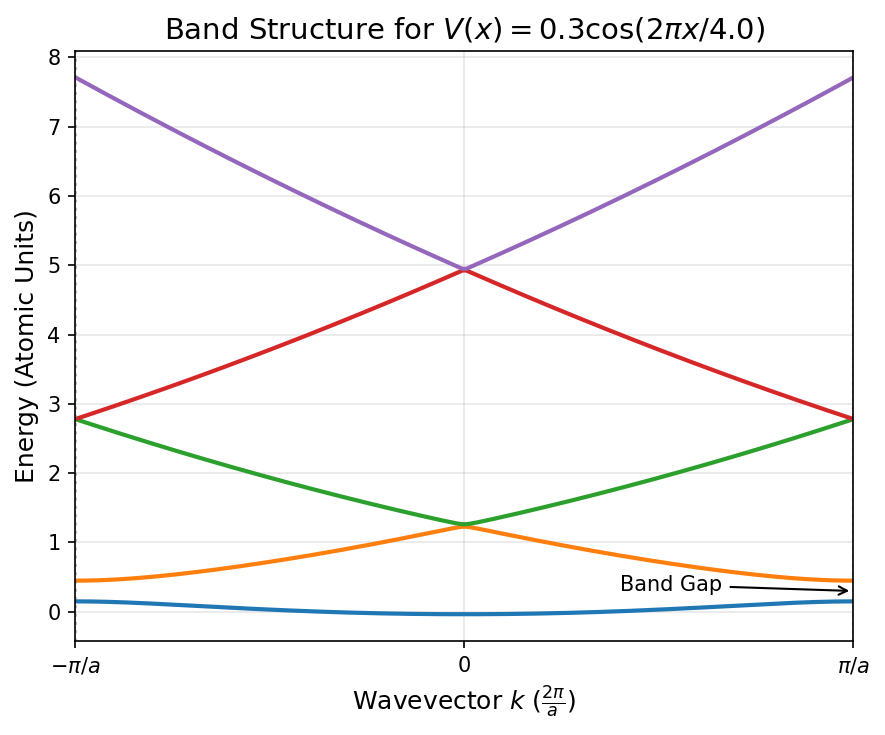

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solve_cosine_potential_band_structure(a=4.0, V0=0.3, ngx=20, nbnds=5):
    """
    Solves the central equation for a cosine potential V(x) = V0 * cos(2*pi*x/a).
    
    Parameters:
    - a: Lattice constant
    - V0: Potential depth
    - ngx: Number of plane waves (reciprocal lattice vectors) to include
    - nbnds: Number of bands to return
    
    Returns:
    - k_vals: k-points in the first Brillouin Zone
    - energies: Eigen-energies for each k-point
    """
    
    # Reciprocal lattice vector basis G = n * (2*pi/a)
    # We choose n from -ngx/2 to +ngx/2
    n_vals = np.arange(-ngx, ngx + 1)
    G_vecs = n_vals * (2 * np.pi / a)
    
    # Hamiltonian Construction parameters
    # The potential is V(x) = V0 * cos(Gx) = (V0/2)*e^{iGx} + (V0/2)*e^{-iGx}
    # So, the coupling U_{G, G'} is V0/2 if |n - n'| = 1, else 0.
    U_coupling = V0 / 2.0
    
    # k-points scan (First Brillouin Zone: -pi/a to pi/a)
    # Normalized k units: -0.5 to 0.5 (where 1 unit = 2pi/a)
    k_norm = np.linspace(-0.5, 0.5, 200)
    k_vals = k_norm * (2 * np.pi / a) # Real k values
    
    energies = []
    
    for k in k_vals:
        # 1. Kinetic Energy Term (Diagonal): (1/2) * (k - G)^2
        # Note: Atomic units (hbar=1, m=1) are used as per the simulation text.
        H_diag = 0.5 * (k - G_vecs)**2
        
        # 2. Potential Energy Term (Off-diagonal)
        # Initialize with zeros
        H_mat = np.diag(H_diag)
        
        # Fill off-diagonals (Tridiagonal matrix for cosine potential)
        # Coupling exists between n and n+1 (neighbors in G-space)
        np.fill_diagonal(H_mat[1:], U_coupling) # Upper diagonal
        np.fill_diagonal(H_mat[:, 1:], U_coupling) # Lower diagonal
        
        # 3. Diagonalization
        # eigh is for Hermitian (symmetric) matrices
        vals = np.linalg.eigvalsh(H_mat)
        
        # Sort and pick lowest 'nbnds' bands
        vals = np.sort(vals)
        energies.append(vals[:nbnds])
        
    return k_norm, np.array(energies)

# ==========================================
# Main Execution & Plotting
# ==========================================

# Parameters from the provided text
a_param = 4.0
V0_param = 0.3

# Calculate Bands
k_axis, E_bands = solve_cosine_potential_band_structure(a=a_param, V0=V0_param)

# Plotting
plt.figure(figsize=(6, 5), dpi=150)

# Plot each band
for i in range(E_bands.shape[1]):
    plt.plot(k_axis, E_bands[:, i], lw=2, label=f'Band {i+1}')

# Formatting
plt.title(f'Band Structure for $V(x) = {V0_param} \cos(2\pi x/{a_param})$', fontsize=14)
plt.ylabel('Energy (Atomic Units)', fontsize=12)
plt.xlabel(r'Wavevector $k$ ($\frac{2\pi}{a}$)', fontsize=12)

# X-axis ticks and labels
plt.xticks([-0.5, 0, 0.5], [r'$-\pi/a$', r'$0$', r'$\pi/a$'])
plt.axvline(0.5, color='gray', linestyle=':', alpha=0.5)
plt.axvline(-0.5, color='gray', linestyle=':', alpha=0.5)

plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 0.5)

# Optional: Indicate Band Gap
# Find max of band 1 and min of band 2 at k=0.5 (Zone Boundary)
gap_low = E_bands[-1, 0] # k=0.5, Band 1
gap_high = E_bands[-1, 1] # k=0.5, Band 2
plt.annotate(f'Band Gap', xy=(0.5, (gap_low+gap_high)/2), xytext=(0.2, (gap_low+gap_high)/2),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.tight_layout()
plt.show()

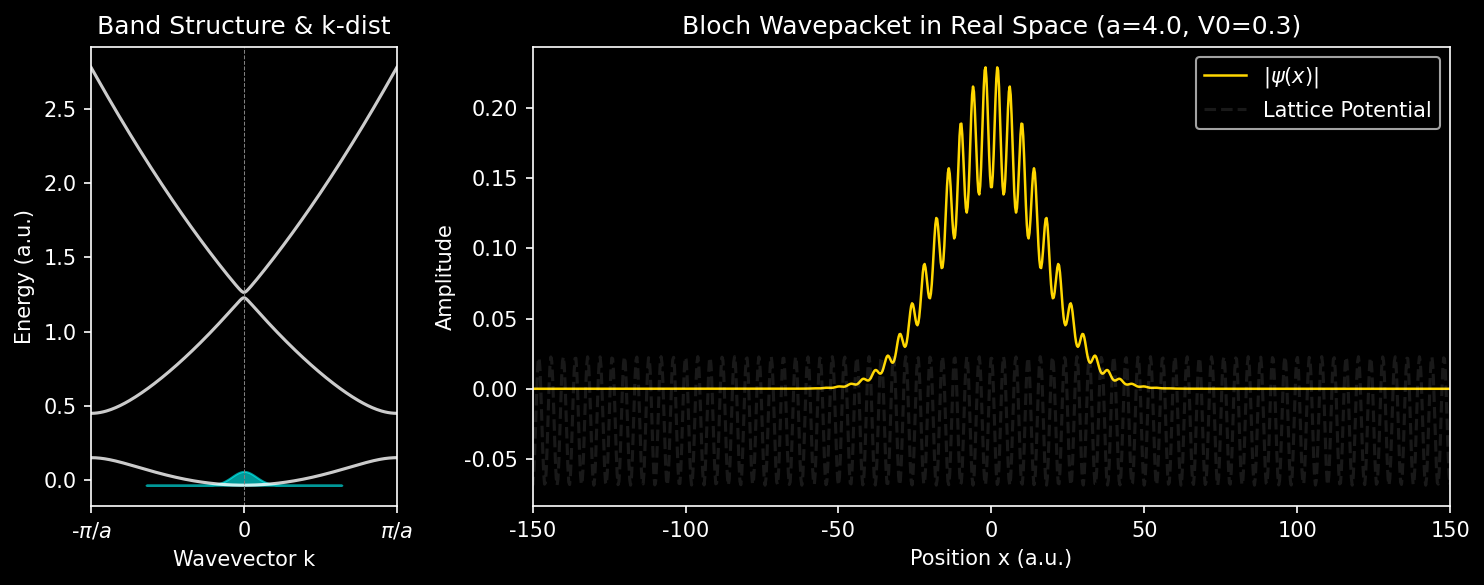

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh

# ==========================================
# 1. TDSE 시뮬레이션 설정 (Turn 3와 동일)
# ==========================================
L = 600.0           # 전체 공간 크기 (a.u.)
N = 2048            # 격자점 수
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]

a = 4.0             # 격자 상수
v0 = 0.3            # 포텐셜 깊이 (V_L = v0 * cos(2pi*x/a))

# 파동 패킷 설정 (시뮬레이션 초기 조건)
k0 = 0.0            # 중심 운동량 (Band 0의 바닥)
sigma_k = 0.04      # 운동량 공간에서의 폭 (좁을수록 실공간에서 넓게 퍼짐)
n0 = 0              # 밴드 인덱스 (0: Ground Band)

# ==========================================
# 2. 밴드 구조 계산 함수 (TDSE 포텐셜 정의 반영)
# ==========================================
def epsilon_nk_cosx_pot_tdse(k, a, v0, ngx=20, nbnds=5):
    '''
    TDSE 설정에 맞춘 코사인 포텐셜의 에너지 밴드 계산
    V(x) = V0 * cos(2*pi*x/a) -> Fourier coeff = V0 / 2
    '''
    # 역격자 벡터 G 생성
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx
    b = 2 * np.pi / a
    Gx = Gx * b
    k_val = k * b # k 입력은 -0.5 ~ 0.5 단위로 받음

    # 운동 에너지 (대각 성분)
    # Atomic Units: hbar=1, m=1 => E = 0.5 * k^2
    lambda_kG = 0.5 * (k_val + Gx)**2
    Hij = np.diag(lambda_kG)

    # 포텐셜 에너지 (비대각 성분)
    # V(x) = V0 * cos(Gx) = (V0/2)e^iGx + (V0/2)e^-iGx
    # 따라서 coupling coefficient는 v0 / 2.0 이어야 함
    coupling = v0 / 2.0
    
    nn = range(ngx)
    # ngx x ngx 행렬에서 +1, -1 대각선 채우기 (Ngmax=1)
    for ii in range(1, 2): 
        Hij[nn[:-ii], nn[ii:]] = coupling
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = coupling
        Hij[nn[ii:], nn[:-ii]] = coupling
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = coupling
    
    E, phi = np.linalg.eigh(Hij) 
    return E[:nbnds], phi[:,:nbnds].T

# ==========================================
# 3. 블로흐 파동 패킷 생성 함수
# ==========================================
def get_gaussian_envelope(k0, sigma_k, nk=100, Nsigma=6):
    # k-space에서 가우시안 포락선 생성
    delta_k = Nsigma * sigma_k
    ktmp = np.linspace(0, delta_k, nk, endpoint=True)
    k_rel = np.r_[-ktmp[::-1][:-1], ktmp] # 0을 중심으로 대칭
    
    k_points = k_rel + k0
    
    # 1st BZ 안으로 접어넣기 (Periodicity)
    k_points[k_points >= 0.5] -= 1.0
    k_points[k_points < -0.5] += 1.0
    
    # 가우시안 가중치
    weights = np.exp(-k_rel**2 / (2 * sigma_k**2))
    weights /= np.sqrt(np.sum(weights**2)) # 가중치 정규화 (에너지 보존)

    return k_points, weights

def construct_bloch_packet_tdse(x, k_points, weights, n0, a, v0, ngx=20):
    # 실공간 격자 x 위에서 파동 패킷 합성
    # w(x) = sum_k F(k) * psi_nk(x)
    
    Nx = x.size
    b = 2 * np.pi / a
    bloch_wp = np.zeros(Nx, dtype=complex)
    
    # 각 k 포인트에 대해 고유함수 계산 후 중첩
    for ik, k in enumerate(k_points):
        # 1. 고유벡터(푸리에 계수 C_G) 계산
        _, C_matrix = epsilon_nk_cosx_pot_tdse(k, a, v0, ngx=ngx, nbnds=n0+1)
        C_G = C_matrix[n0] # n0번째 밴드의 계수들
        
        # 2. 역격자 벡터 G 준비
        Gx_int = np.arange(ngx, dtype=int)
        Gx_int[ngx // 2 + 1:] -= ngx
        G_vecs = Gx_int * b
        
        # 3. 평면파 기저로 해당 k의 Bloch 함수 u_nk(x)e^ikx 구성
        # psi_nk(x) = sum_G C_G * exp(i(k+G)x)
        # 여기서 k는 -0.5~0.5 정규화 단위이므로 실제 k는 k*b
        psi_k = np.zeros(Nx, dtype=complex)
        real_k = k * b
        
        for ig, G in enumerate(G_vecs):
            psi_k += C_G[ig] * np.exp(1j * (real_k + G) * x)
            
        # 4. 가중치 곱해서 누적
        bloch_wp += weights[ik] * psi_k
        
    # 최종 정규화 (Norm = 1)
    norm = np.sqrt(np.sum(np.abs(bloch_wp)**2) * dx)
    bloch_wp /= norm
    
    return bloch_wp

# ==========================================
# 4. 실행 및 시각화
# ==========================================
if __name__ == "__main__":
    # A. 데이터 생성
    # 1. 가우시안 포락선 (k-space)
    kwp, fk = get_gaussian_envelope(k0, sigma_k, nk=150, Nsigma=8)
    
    # 2. 전체 밴드 구조 계산 (Plotting용)
    k_bz = np.linspace(-0.5, 0.5, 200)
    nbnds_plot = 3
    Enk = np.array([epsilon_nk_cosx_pot_tdse(k, a, v0, nbnds=nbnds_plot)[0] for k in k_bz])
    
    # 3. 실공간 파동 패킷 합성
    psi_real = construct_bloch_packet_tdse(x, kwp, fk, n0, a, v0)

    # B. 그래프 그리기 (Figure 2 스타일)
    import matplotlib as mpl
    mpl.rcParams['axes.unicode_minus'] = False
    plt.style.use('dark_background')

    fig = plt.figure(figsize=(10, 4), dpi=150)
    
    # Layout: 왼쪽(Band) vs 오른쪽(Wavepacket) 비율 1:3
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 3])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # --- Plot 1: Band Structure & k-distribution ---
    # 밴드 그리기
    for i in range(nbnds_plot):
        ax1.plot(k_bz, Enk[:, i], color='white', lw=1.5, alpha=0.8)
    
    # 파동 패킷의 운동량 분포 (Cyan Area)
    # 시각화를 위해 에너지 밴드 위에 덧그림 (스케일링 필요)
    emin = Enk[:, 0].min()
    band_width = Enk[:, 0].max() - emin
    scaled_fk = fk / fk.max() * (band_width * 0.5) # 높이 조절
    
    # k0 위치의 에너지 값 찾기
    e_k0 = epsilon_nk_cosx_pot_tdse(k0, a, v0, nbnds=1)[0][0]
    
    ax1.fill_between(kwp, e_k0, e_k0 + scaled_fk, color='cyan', alpha=0.6, label='Wavepacket (k)')
    
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_xticks([-0.5, 0, 0.5])
    ax1.set_xticklabels([r'-$\pi/a$', '0', r'$\pi/a$'])
    ax1.set_xlabel('Wavevector k')
    ax1.set_ylabel('Energy (a.u.)')
    ax1.set_title('Band Structure & k-dist')
    ax1.axvline(0, color='gray', ls='--', lw=0.5)

    # --- Plot 2: Real Space Wavepacket ---
    # 파동함수 크기 |psi(x)|
    ax2.plot(x, np.abs(psi_real), color='gold', lw=1.2, label=r'$|\psi(x)|$')
    
    # 포텐셜 배경 (선택적 표시) - 스케일 맞춰서 흐리게
    v_plot = (np.cos(2*np.pi*x/a) * v0)
    # v_plot을 psi 스케일에 맞춰 시각화용으로 변환
    v_plot_scaled = v_plot / v0 * (np.max(np.abs(psi_real))*0.2) 
    ax2.plot(x, v_plot_scaled - np.max(np.abs(psi_real))*0.1, color='white', alpha=0.1, ls='--', label='Lattice Potential')

    ax2.set_xlim(-150, 150) # 중심부 확대 (전체 L=600 중)
    ax2.set_xlabel('Position x (a.u.)')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Bloch Wavepacket in Real Space (a={a}, V0={v0})')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_72249/666311170.py:134: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  norm = np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))


Bloch Period: 314.16 a.u.
Total Steps: 942
Propagating for 942 steps...


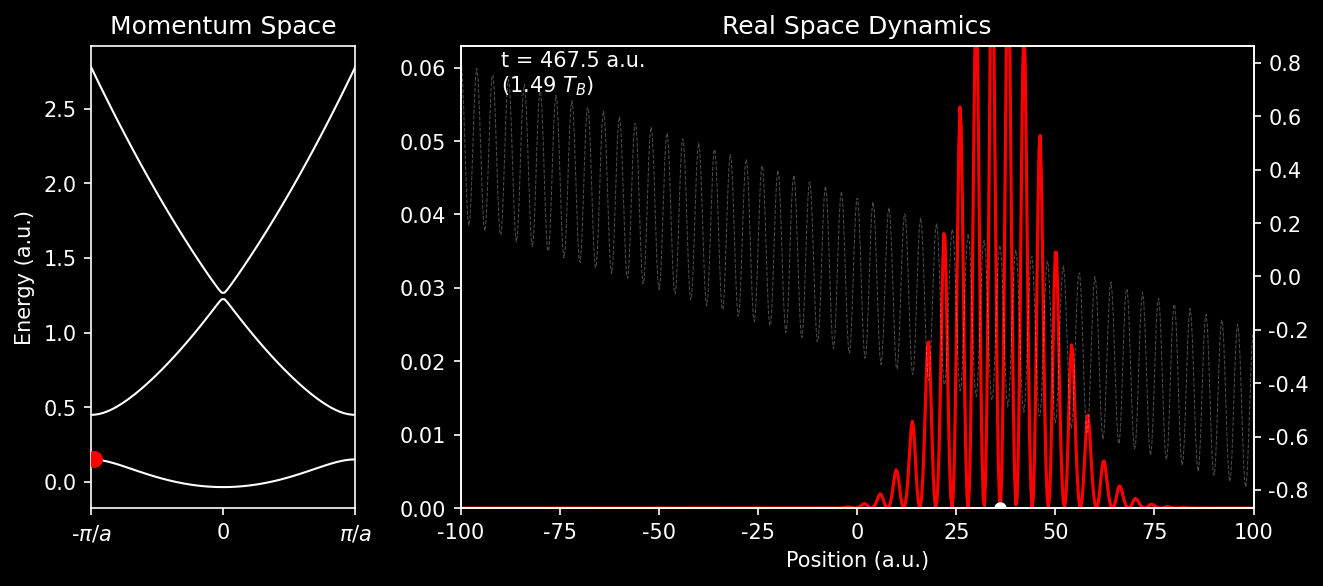

In [4]:
#!/usr/bin/env python

import os
import numpy as np
import scipy.sparse as spa
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import AutoMinorLocator

# ==========================================
# 1. Crank-Nicolson Solver (TDSE Propagator)
# ==========================================
def CrankNicolson(psi0, V_diag, x, dt, N_steps=100):
    '''
    Crank-Nicolson method for the 1D Schrodinger equation.
    Uses Sparse Matrix Linear Algebra for efficiency.
    '''
    J  = x.size
    dx = x[1] - x[0]

    # Potential Matrix (Diagonal)
    V_mat = spa.diags(V_diag)
    
    # Kinetic Energy Operator (Finite Difference, Tridiagonal)
    # T = -1/2 * d^2/dx^2
    ones = np.ones(J)
    T_mat = (-0.5 / dx**2) * spa.spdiags([ones, -2*ones, ones], [-1, 0, 1], J, J)

    # Hamiltonain H = T + V
    H = T_mat + V_mat

    # Evolution Operators: (1 - iH dt/2) psi(t+1) = (1 + iH dt/2) psi(t)
    # Note: Using Atomic Units (hbar = 1)
    lhs = spa.eye(J) + (1j * 0.5 * dt) * H
    rhs = spa.eye(J) - (1j * 0.5 * dt) * H
    
    # Pre-factorize LHS for speed (since H is time-independent here)
    lhs = lhs.tocsc()
    LU = splu(lhs)

    # Storage for snapshots
    PSI_t = np.zeros((J, N_steps), dtype=complex)
    psi_current = psi0.copy()
    PSI_t[:, 0] = psi_current

    print(f"Propagating for {N_steps} steps...")
    for n in range(N_steps - 1):
        # Solve A * x = b where b = rhs * psi_current
        b = rhs.dot(psi_current)
        psi_current = LU.solve(b)
        PSI_t[:, n+1] = psi_current

    return PSI_t

# ==========================================
# 2. Band Structure Calculation (Corrected)
# ==========================================
def epsilon_nk_cosx_pot(k, a, v0, ngx=20, nbnds=5):
    '''
    Calculate Eigen-energies for V(x) = V0 * cos(2pi x / a)
    Correction: Coupling coefficient is V0 / 2, not V0.
    '''
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx
    b = 2 * np.pi / a
    
    # G vectors and k in real units
    G_vec = Gx * b
    k_val = k * b 

    # Kinetic Energy (Diagonal): 0.5 * k^2
    lambda_kG = 0.5 * (k_val + G_vec)**2
    Hij = np.diag(lambda_kG)

    # Potential Energy (Off-diagonal): V0 / 2
    coupling = v0 / 2.0
    nn = range(ngx)
    
    # Fill tridiagonal elements (G - G' = +/- 1)
    for ii in range(1, 2):
        Hij[nn[:-ii], nn[ii:]] = coupling
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = coupling
        Hij[nn[ii:], nn[:-ii]] = coupling
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = coupling
    
    E, phi = np.linalg.eigh(Hij) 
    return E[:nbnds], phi[:,:nbnds].T

# ==========================================
# 3. Wavepacket Construction
# ==========================================
def get_bloch_wavepacket_gaussian_envelop(k0, sigma_k, nk=100, Nsigma=6):
    # Create Gaussian weights in k-space
    delta_k = Nsigma * sigma_k
    ktmp = np.linspace(0, delta_k, nk, endpoint=True)
    k_rel = np.r_[-ktmp[::-1][:-1], ktmp]
    
    k_points = k_rel + k0
    
    # Fold into 1st BZ [-0.5, 0.5]
    k_points[k_points >= 0.5] -= 1.0
    k_points[k_points < -0.5] += 1.0
    
    weights = np.exp(-k_rel**2 / (2 * sigma_k**2))
    weights /= np.sqrt(np.sum(weights**2)) # Normalize weights
    
    return k_points, weights

def construct_blochwp_tdse(x, k_points, weights, n0, a, v0, ngx=20):
    Nx = x.size
    b = 2 * np.pi / a
    bloch_wp = np.zeros(Nx, dtype=complex)
    
    for ik, k in enumerate(k_points):
        # Get eigenvector coefficients C_G
        _, C_matrix = epsilon_nk_cosx_pot(k, a, v0, ngx=ngx, nbnds=n0+1)
        C_G = C_matrix[n0]
        
        # Reconstruct Bloch state in Real Space
        Gx_int = np.arange(ngx, dtype=int)
        Gx_int[ngx // 2 + 1:] -= ngx
        G_vecs = Gx_int * b
        
        # psi_nk(x) = e^{ikx} * u_nk(x) = sum_G C_G * e^{i(k+G)x}
        real_k = k * b
        psi_k = np.zeros(Nx, dtype=complex)
        for ig, G in enumerate(G_vecs):
            psi_k += C_G[ig] * np.exp(1j * (real_k + G) * x)
            
        bloch_wp += weights[ik] * psi_k
        
    # Spatial Normalization
    norm = np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))
    return bloch_wp / norm

# ==========================================
# 4. Main Simulation & Visualization
# ==========================================
if __name__ == "__main__":
    # --- A. System Parameters (Updated for User Settings) ---
    L  = 600.0          # Space size
    N  = 2048           # Grid points
    x  = np.linspace(-L/2, L/2, N)
    dx = x[1] - x[0]
    
    a  = 4.0            # Lattice constant
    v0 = 0.3            # Potential depth
    b  = 2 * np.pi / a

    # --- B. Initial Bloch Wavepacket ---
    n0      = 0         # Band index
    k0      = 0.0       # Center momentum
    sigma_k = 0.04      # Momentum spread
    ngx     = 21        # No. of plane waves
    
    kwp, fk = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k, nk=100)
    psi0 = construct_blochwp_tdse(x, kwp, fk, n0, a, v0, ngx)

    # --- C. Time Evolution Setup ---
    # External Field
    F_field = 0.005     # Electric field strength (small enough for Bloch osc.)
    
    # Potential: Lattice + Electric Field
    # Note: V_L = v0 * cos(2pi x/a)
    V_x = v0 * np.cos(b * x) - F_field * x
    
    # Time Parameters
    # Bloch Period T_B = 2pi / (a * F)
    T_bloch = 2 * np.pi / (a * F_field)
    dt = 0.5
    total_time = 1.5 * T_bloch  # Simulate 1.5 periods
    NSW = int(total_time / dt)  # Number of steps

    print(f"Bloch Period: {T_bloch:.2f} a.u.")
    print(f"Total Steps: {NSW}")

    # Run Propagation
    PSI_t = CrankNicolson(psi0, V_x, x, dt, NSW)

    # --- D. Analysis (Expectation Values) ---
    # Position <x>
    prob_density = np.abs(PSI_t)**2
    norm_t = np.sum(prob_density, axis=0) * dx
    X_avg = np.sum(prob_density * x[:, None], axis=0) * dx / norm_t
    
    # Band Structure for Plotting
    k_bz = np.linspace(-0.5, 0.5, 100)
    Enk = np.array([epsilon_nk_cosx_pot(k, a, v0, nbnds=3)[0] for k in k_bz])
    
    # Projected Momentum (Simplified Center of Mass in k-space)
    # k(t) = k(0) - F*t (Acceleration Theorem)
    K_center_t = k0 - (F_field * np.arange(NSW) * dt) * (a / (2*np.pi))
    # Fold back into 1st BZ for visualization
    K_center_t = (K_center_t + 0.5) % 1.0 - 0.5

    # --- E. Visualization (Animation) ---
    mpl.rcParams['axes.unicode_minus'] = False
    plt.style.use('dark_background')

    fig = plt.figure(figsize=(10, 4), dpi=150)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 3])
    ax_band = fig.add_subplot(gs[0])
    ax_real = fig.add_subplot(gs[1])
    ax_pot = ax_real.twinx() # For Potential plotting

    # 1. Band Structure Plot
    for i in range(3):
        ax_band.plot(k_bz, Enk[:, i], 'w-', lw=1)
    
    # Moving dot in k-space
    scat_k = ax_band.scatter([], [], c='r', s=50, zorder=5)
    
    ax_band.set_xlim(-0.5, 0.5)
    ax_band.set_xticks([-0.5, 0, 0.5])
    ax_band.set_xticklabels([r'-$\pi/a$', '0', r'$\pi/a$'])
    ax_band.set_title('Momentum Space')
    ax_band.set_ylabel('Energy (a.u.)')

    # 2. Real Space Plot
    line_psi, = ax_real.plot([], [], 'r-', lw=1.5, label=r'$|\psi|^2$')
    line_xavg, = ax_real.plot([], [], 'wo', ms=5, label=r'$\langle x \rangle$')
    
    # Potential (Static background)
    # Plot only central part to avoid huge vertical scale
    mask = (x > -100) & (x < 100)
    ax_pot.plot(x[mask], V_x[mask], 'w--', lw=0.5, alpha=0.3)
    
    ax_real.set_xlim(-100, 100) # Zoom in to see oscillation
    ax_real.set_ylim(0, np.max(np.abs(psi0)**2)*1.2)
    ax_real.set_xlabel('Position (a.u.)')
    ax_real.set_title('Real Space Dynamics')
    
    time_text = ax_real.text(0.05, 0.9, '', transform=ax_real.transAxes, color='white')

    def init():
        scat_k.set_offsets(np.empty((0, 2)))
        line_psi.set_data([], [])
        line_xavg.set_data([], [])
        time_text.set_text('')
        return scat_k, line_psi, line_xavg, time_text

    def update(frame):
        # Speed up animation: skip frames
        idx = frame * 5 
        if idx >= NSW: idx = NSW - 1
        
        # Update k-space dot
        # Map energy of current band (approximate)
        # Simply place dot on Band 0 curve for visualization
        # Find closest k index
        k_curr = K_center_t[idx]
        k_idx = np.argmin(np.abs(k_bz - k_curr))
        e_curr = Enk[k_idx, 0]
        scat_k.set_offsets([[k_curr, e_curr]])
        
        # Update Real Space
        line_psi.set_data(x, np.abs(PSI_t[:, idx])**2)
        line_xavg.set_data([X_avg[idx]], [0])
        
        # Update Time Text
        t_curr = idx * dt
        time_text.set_text(f't = {t_curr:.1f} a.u.\n({t_curr/T_bloch:.2f} $T_B$)')
        
        return scat_k, line_psi, line_xavg, time_text

    ani = animation.FuncAnimation(fig, update, frames=NSW//5, init_func=init, blit=True, interval=30)
    
    # Save or Show
    # ani.save('bloch_oscillation_tdse.gif', writer='pillow', fps=30)
    # save as video
    ani.save('bloch_oscillation_tdse.mp4', writer='ffmpeg', dpi=300)
    plt.show()